First load the training data, you can find this file in the github repo

In [100]:
import pandas as pd

train_df = pd.read_csv('data_train.csv')

In [101]:
print(train_df.head(n=5))
print(train_df.shape)

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  
(6250, 13)


So we can see from the shape that we have 6250 rows of data for the 12 provided air quality features:

1. NMHC(GT): hourly averaged overall Non Metanic HydroCarbons concentration in mi-
crog/ m3
2. C6H6(GT): hourly averaged Benzene concentration in microg/m3
3. PT08.S2(NMHC): hourly averaged sensor response to NMHC
4. NOx(GT): hourly averaged NOx concentration in ppb
5. PT08.S3(NOx): hourly averaged sensor response for NOx
6. NO2(GT): hourly averaged NO2 concentration in microg/m3
7. PT08.S4(NO2): hourly averaged sensor response for NO2
8. PT08.S5(O3): hourly averaged sensor response for O3
9. T: Temperature in C
10. RH: Relative Humidity
11. AH: Absolute Humidity
12. PT08.S1(CO): TARGET VARIABLE - hourly averaged sensor response for CO

In [102]:
train_df.dropna(inplace=True)
train_df.drop("Unnamed: 0", axis=1, inplace=True)
train_df

,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,797.0,-200.0,2.1,593.0,146.0,1212.0,72.0,984.0,494.0,10.8,49.7,0.6429
1,1282.0,-200.0,11.0,1013.0,354.0,545.0,141.0,1384.0,1287.0,17.4,50.6,0.9989
2,891.0,-200.0,7.6,882.0,342.0,885.0,149.0,950.0,894.0,7.8,33.9,0.3594
3,1285.0,-200.0,18.1,1243.0,481.0,599.0,173.0,1815.0,1582.0,26.4,41.9,1.4237
4,892.0,-200.0,7.3,869.0,71.0,953.0,77.0,1363.0,632.0,37.4,14.7,0.9295
...,...,...,...,...,...,...,...,...,...,...,...,...
6244,918.0,-200.0,4.5,737.0,220.0,1007.0,105.0,1030.0,703.0,9.6,53.9,0.6425
6245,824.0,-200.0,2.2,602.0,54.0,1138.0,44.0,1337.0,593.0,21.1,63.8,1.5817
6246,1003.0,-200.0,3.7,694.0,156.0,876.0,116.0,976.0,663.0,7.7,53.0,0.5572
6247,894.0,-200.0,4.0,709.0,46.0,997.0,53.0,1432.0,853.0,24.0,37.8,1.1077


We can use .dropna to delete rows with na values and also delete the "Unnamed: 0" column which appears to be a sample number.

Now lets extract just the features and the target variable.

In [103]:
train_features_df = train_df.drop("PT08.S1(CO)", axis=1)
train_labels_df = train_df["PT08.S1(CO)"]

print(train_features_df.shape)
print(train_labels_df.shape)

(6173, 11)
(6173,)


And lets also create a normalized dataset as well which we will use for logistic regression later on.

Lets try with data centering, so each feature $x_j = \frac{x_j - x̄_j} {σ^{2}_j}$

In [104]:
def center_column(col):
  return (col - col.mean()) / col.std() if col.name != 'B0' else col

train_features_df['B0'] = 1
train_features_df = train_features_df[['B0'] + [col for col in train_features_df.columns if col != 'B0']]

train_features_normalized = train_features_df.apply(center_column).to_numpy()

Now we can implement a linear regression model to regress on the target variable using our 11 features.

We need to minimise the Residual Sum of Squares (RSS), that is the equation $$RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^{2}$$ If we have $$\hat{y_i}=x_i^{T}w$$ the matrix form is $$RSS = (y - Xw)^{T}(y - Xw) = y^{T}y - y^{T}Xw - X^{T}w^{T}y + X^{T}w^{T}Xw$$ Now we want the point where $$\frac{\partial RSS}{\partial w} = 0$$
$$\frac{\partial RSS}{\partial w} = -yX^{T} - yX^{T} + 2X^{T}Xw = -2yX^{T} + 2X^{T}Xw = 0$$Divide by 2 we have $$-yX^T + X^{T}Xw = 0$$ Add the left term $$X^TXw = yX^T$$ which is where we have the solution $$w = (X^TX)^{-1}X^Ty$$


In [105]:
import numpy as np
class LinearRegression:
  def __init__(self):
    self.weights = None

  def fit(self, X, y):
    Xt = np.transpose(X)
    self.weights = np.dot(np.dot(np.linalg.inv(np.dot(Xt, X)), Xt), y)

  def predict(self, X):
    return np.dot(X, self.weights)

We will need to add the bias term or $β_0$, we can just add a column of ones to the training data for this.

In [106]:
train_features_df['B0'] = 1
train_features_df = train_features_df[['B0'] + [col for col in train_features_df.columns if col != 'B0']]

train_features = train_features_df.to_numpy()
train_labels = train_labels_df.to_numpy()

In [107]:
model = LinearRegression()
model.fit(train_features, train_labels)

predictions = model.predict(train_features)

print(f"RMSE: {np.sqrt(np.mean((train_labels - predictions)**2))}")

RMSE: 71.0793559885694


Lets try validating our model accross 5 folds

In [108]:
num_folds = 5
fold_size = train_features.shape[0] // num_folds
fold_RMSE = np.zeros((num_folds))

for fold_num in range(num_folds):
  start = fold_size * fold_num
  end = min(start + fold_size, train_features.shape[0])

  train_fold_features = pd.concat([train_features_df[:start], train_features_df[end:]])
  validation_fold_features = train_features[start:end]

  train_fold_labels = pd.concat([train_labels_df[:start], train_labels_df[end:]])
  validation_fold_labels = train_labels[start:end]

  model = LinearRegression()
  model.fit(train_fold_features, train_fold_labels)
  fold_RMSE[fold_num] = np.sqrt(np.mean((validation_fold_labels - model.predict(validation_fold_features))**2))

  print(f"Validation RMSE for fold {fold_num}: {fold_RMSE[fold_num]}")

print(f"Mean RMSE Across all 5 folds: {np.mean(fold_RMSE)}")
print(f"RMSE Std Deviation: {np.std(fold_RMSE)}")

Validation RMSE for fold 0: 70.12422149234686
Validation RMSE for fold 1: 72.96008688643394
Validation RMSE for fold 2: 67.9407155362109
Validation RMSE for fold 3: 72.52655478014893
Validation RMSE for fold 4: 72.59085808021005
Mean RMSE Across all 5 folds: 71.22848735507014
RMSE Std Deviation: 1.9270867441944193


So it seems to be somewhat stable indicating that it is working

Now lets try a logistic regression model for binary classification. PT08.S1(CO) values greater than 1000 will be 1 else 0.

In [109]:
binary_train_labels = np.where(train_labels > 1000, 1, 0)

In [110]:
import random
from matplotlib import pyplot as plt

class LogisticRegression:
  def __init__ (self, D = 2, lr = 0.1, lambda_param = 0.1, max_iter = 1000):
    self.lr = lr
    self.w = np.random.randn(D, 1)
    self.max_iter = max_iter
    self.lambda_param = lambda_param
    self.random_feature = random.sample(range(1,12), 1)

  def fit(self, X, y, plot=True):
    for i in range(self.max_iter):
      logits = np.matmul(X, self.w)
      grad = (((1/(1+np.exp(-logits)))-y.reshape(-1, 1)) * X).mean(axis=0, keepdims=True).T + 2 * self.lambda_param * self.w
      self.w -= self.lr * grad
      if plot and i % 100 == 0:
        self.iter = i
        self.plot(X, y, self.predict(X))

  def predict(self, X):
    logits = np.matmul(X, self.w)
    return np.round(1/(1+np.exp(-logits))).squeeze()

  def plot(self, X, y, preds = None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax_gt, ax_pred = ax
    ax_gt.scatter(X[:, self.random_feature[0]], y, c = y)
    ax_gt.set_title('GROUND TRUTH')
    ax_pred.scatter(X[:, self.random_feature[0]], y, c = preds)
    ax_pred.set_title('PREDS')
    fig.suptitle(f"ITERATION: {self.iter}", fontsize=30)
    plt.show()

We initialize the model with the input dimensions, learning rate, lamnda parameter for regularization (Ridge/L2 Regularization in this case), and number of training iterations. Initally the weights are random. Then we can call the fit function to calculate the gradient: $$
\nabla_w NLL(w) = \frac{1}{N} \sum_{n=1}^N (\sigma(w^Tx) - y_n) x_n + \lambda w,
$$
and then update the weights using gradient descent.
$$w = w - α\nabla_w NLL(w)$$

The other two functions predict and plot just multiply an input by our weights to get the prediction and then plot some predictions verse the expectation.

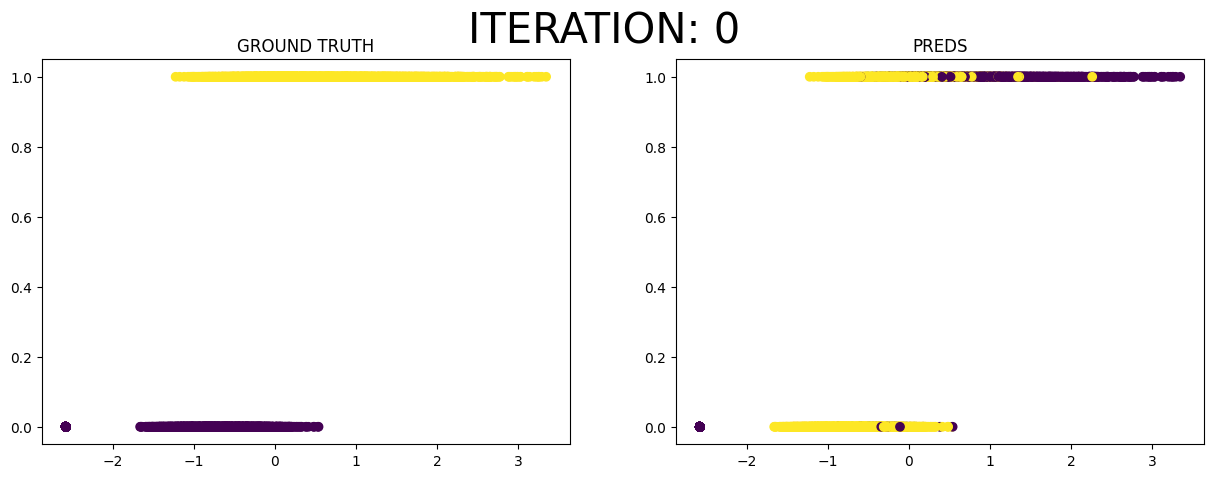

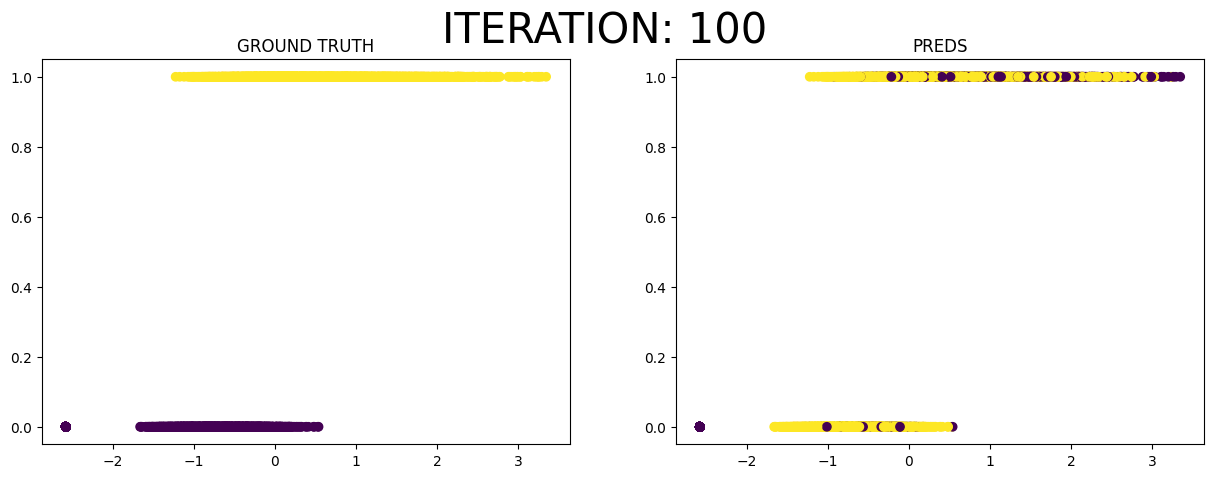

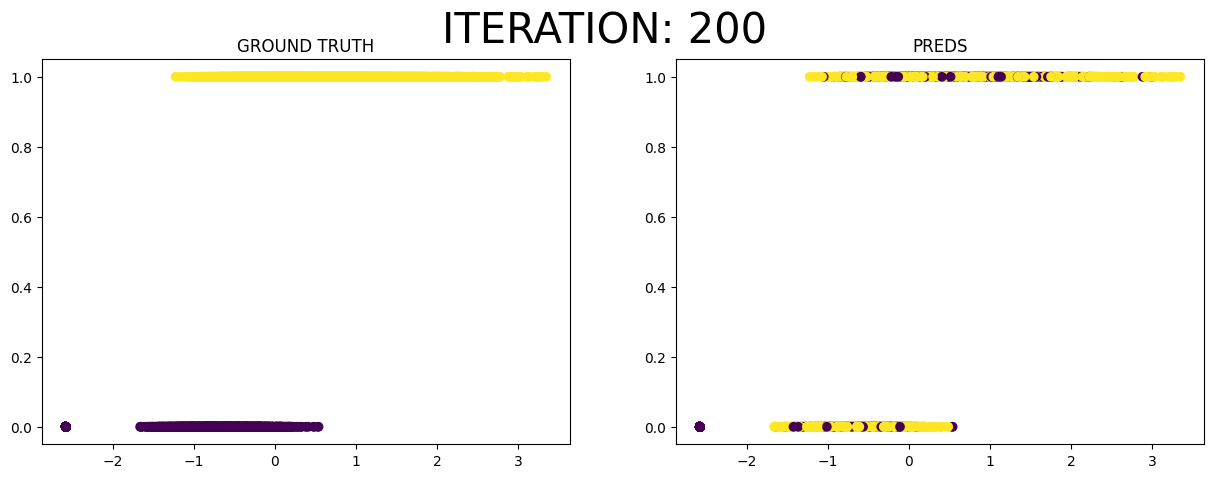

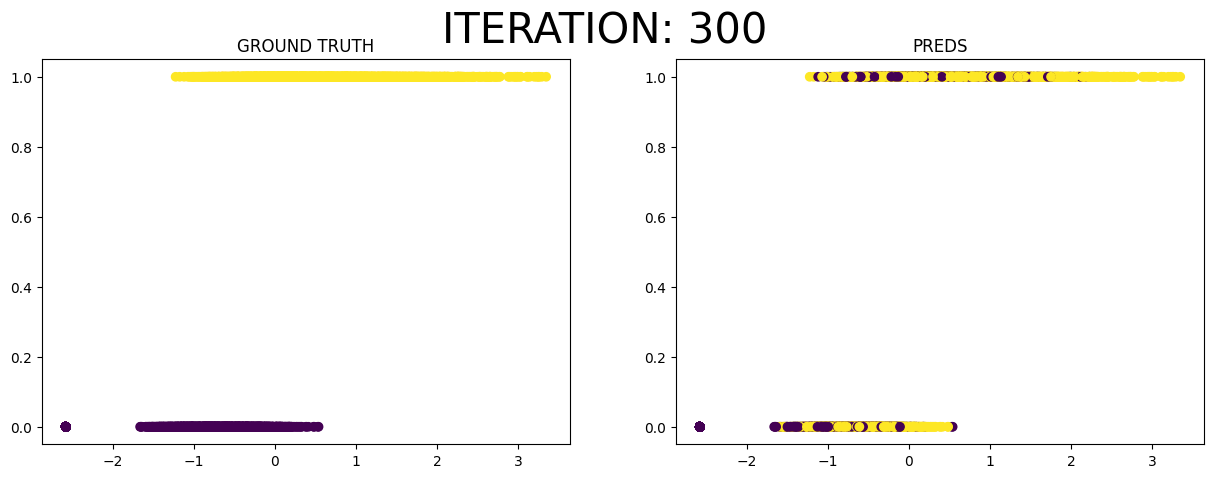

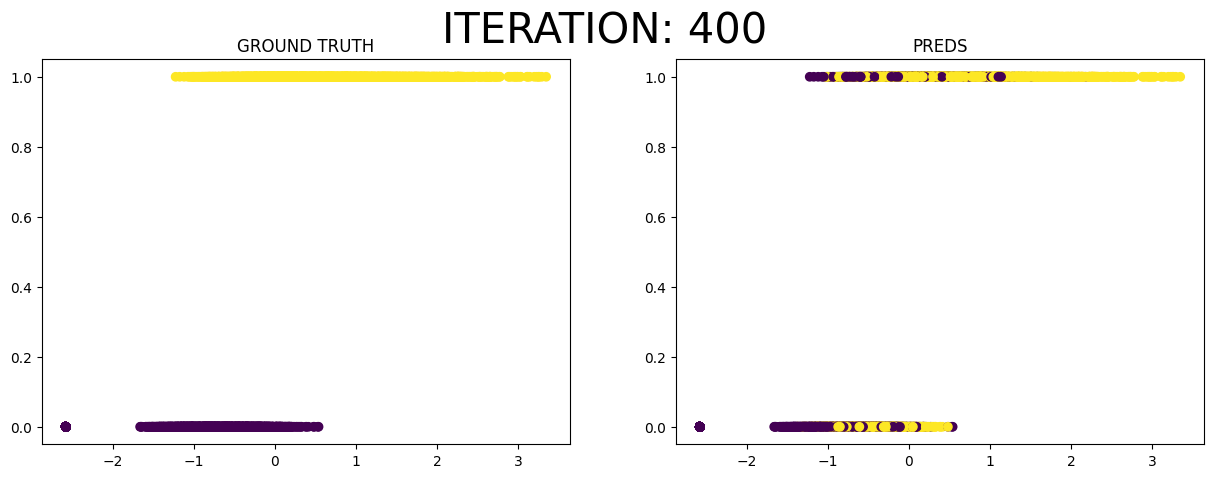

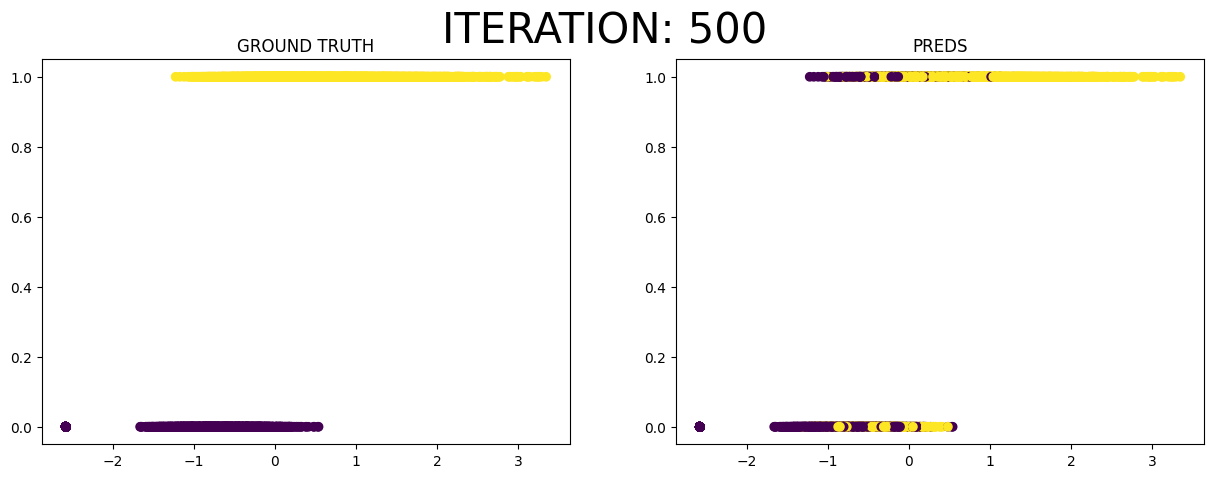

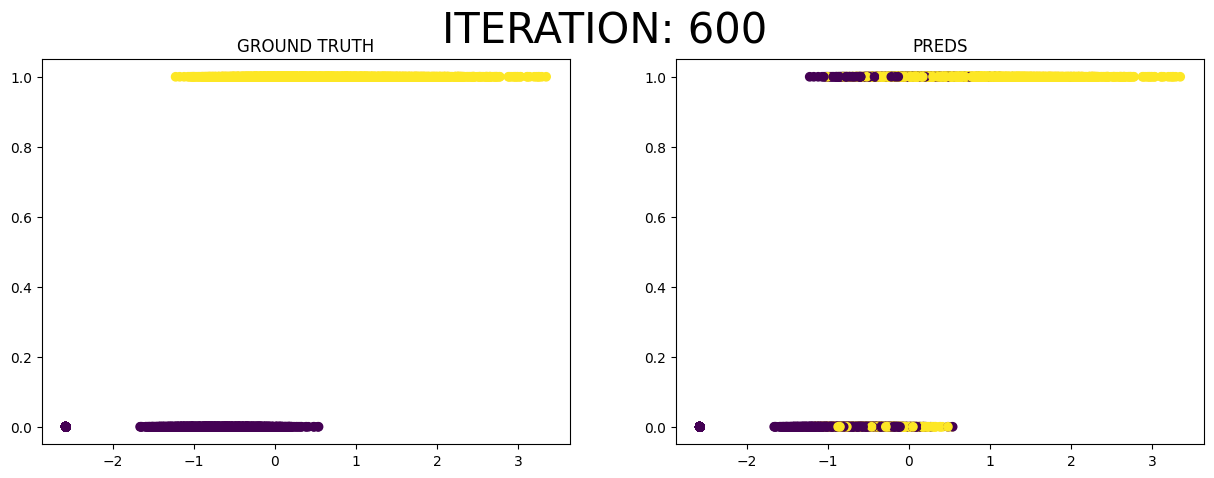

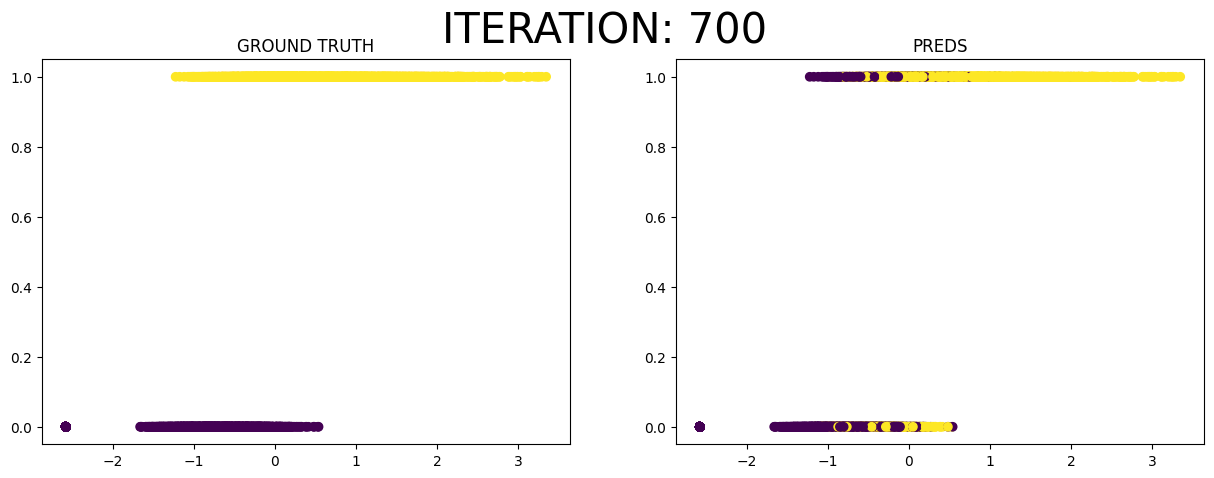

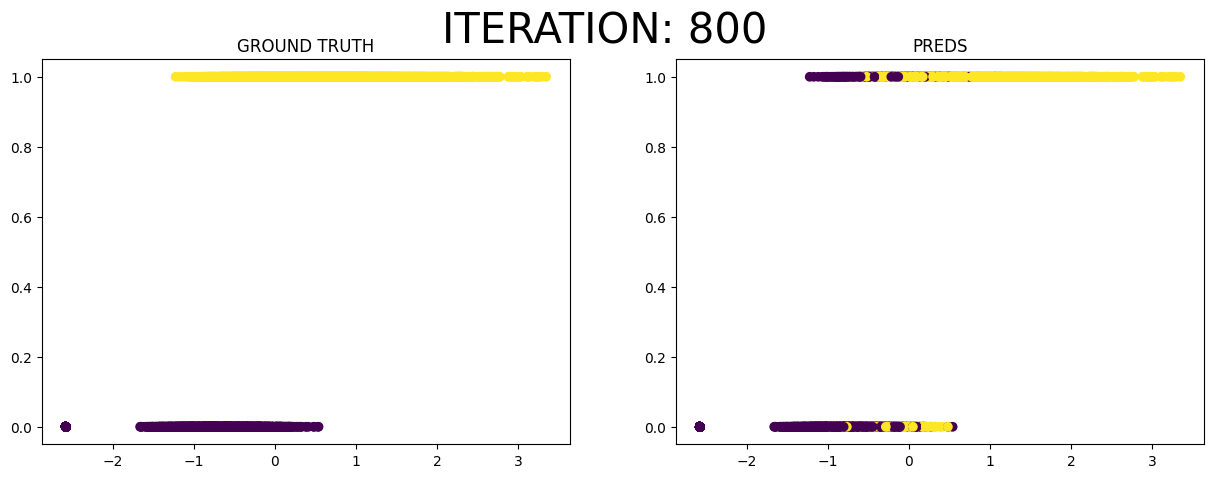

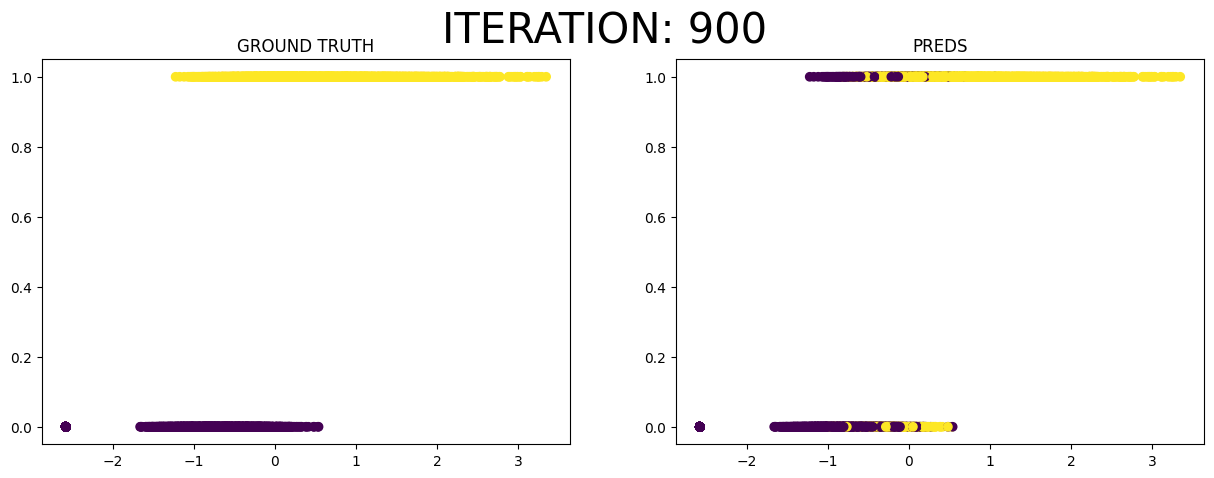

In [111]:
model = LogisticRegression(D = 12, lr = 0.005, lambda_param = 0.1, max_iter = 1000)
model.fit(train_features_normalized, binary_train_labels)

So we can see over the iterations it is learning to fit the sigmoid function to the data.

Now lets do another 5 fold validation. For binary classification there are 4 main performance measures:
$$Accuracy = \frac{TP+TN} {TP+TN+FP+FN} $$
$$Precision = \frac{TP} {TP+FP} $$
$$Recall = \frac{TP} {TP+FN} $$
$$F1 = \frac{2TP} {2TP+FP+FN} $$

In [112]:
num_folds = 5
fold_Accuracy = np.zeros((num_folds))
fold_Precision = np.zeros((num_folds))
fold_Recall = np.zeros((num_folds))
fold_F1 = np.zeros((num_folds))

for fold_num in range(num_folds):
  start = fold_size * fold_num
  end = min(start + fold_size, train_features_normalized.shape[0])

  train_fold_features = np.concatenate((train_features_normalized[:start], train_features_normalized[end:]))
  validation_fold_features = train_features_normalized[start:end]

  train_fold_labels = np.concatenate((binary_train_labels[:start], binary_train_labels[end:]))
  validation_fold_labels = binary_train_labels[start:end]

  model = LogisticRegression(D=12, lr=0.005, lambda_param=0.5, max_iter=1000)
  model.fit(train_fold_features, train_fold_labels, plot=False)

  predictions = model.predict(validation_fold_features)

  tp = np.sum((predictions == 1) & (validation_fold_labels == 1))
  fp = np.sum((predictions == 1) & (validation_fold_labels == 0))
  tn = np.sum((predictions == 0) & (validation_fold_labels == 0))
  fn = np.sum((predictions == 0) & (validation_fold_labels == 1))

  fold_Accuracy[fold_num] = (tp+tn) / (tp+tn+fp+fn)
  fold_Precision[fold_num] = tp / (tp+fp)
  fold_Recall[fold_num] = tp / (tp+fn)
  fold_F1[fold_num] = (2*tp) / (2*tp + fp + fn)
  print(f"Fold {fold_num+1} - Accuracy {fold_Accuracy[fold_num]:.2f}, Precision {fold_Precision[fold_num]:.2f}, Recall {fold_Recall[fold_num]:.2f}, F1 {fold_F1[fold_num]:.2f}")

print(f"Accuracy  - Avg: {np.mean(fold_Accuracy):.2f} StdDev: {np.std(fold_Accuracy):.2f}")
print(f"Precision - Avg: {np.mean(fold_Precision):.2f} StdDev: {np.std(fold_Precision):.2f}")
print(f"Recall    - Avg: {np.mean(fold_Recall):.2f} StdDev: {np.std(fold_Recall):.2f}")
print(f"F1        - Avg: {np.mean(fold_F1):.2f} StdDev: {np.std(fold_F1):.2f}")

Fold 1 - Accuracy 0.89, Precision 0.94, Recall 0.86, F1 0.90
Fold 2 - Accuracy 0.91, Precision 0.95, Recall 0.89, F1 0.92
Fold 3 - Accuracy 0.88, Precision 0.93, Recall 0.85, F1 0.89
Fold 4 - Accuracy 0.87, Precision 0.93, Recall 0.84, F1 0.88
Fold 5 - Accuracy 0.88, Precision 0.93, Recall 0.88, F1 0.90
Accuracy  - Avg: 0.88 StdDev: 0.01
Precision - Avg: 0.94 StdDev: 0.01
Recall    - Avg: 0.87 StdDev: 0.02
F1        - Avg: 0.90 StdDev: 0.01


Its clear that the model is learning quite well.